# Network analysis for coauthors - modularity

This looks at modularity of the main subgraph.

In [1]:
import sklearn
sklearn.__version__

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


'0.24.1'

In [2]:
%load_ext autoreload
%autoreload 2

from src.util import load_coauthor_nx, ddir_analysis, fn_nodes, fn_statoids, get_spp_df

import community
import networkx as nx
from operator import itemgetter
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import skbio.diversity.alpha as b
import math
import random

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn import preprocessing
import numpy as np

In [3]:
# Params
seed = 2021
random.seed(seed)

# Load graph
(G, nodes) = load_coauthor_nx() # abstracted into src


Name: 
Type: Graph
Number of nodes: 391
Number of edges: 510
Average degree:   2.6087


## Communities

In [4]:
# Read data
nodes_df = pd.read_csv(fn_nodes)
statoids = pd.read_csv(fn_statoids)
statoids = area_dict = dict(zip(statoids.DL, statoids.Country))

spp = get_spp_df()

spp.head(3)

/home/ejysoh/miniconda3/envs/msc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (22,30,60,61,65,86,89,106,117) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/mnt/c/_dev/msc/thesis/2020-08-31-jsa-type-v2-ch3-coauth/src/util.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spp = spp[~spp['duplicated']][


,idx,date,status,duplicated,full_name_of_describer
1,2,2004,Valid species,False,Carlos Hernan Vergara
1,2,2004,Valid species,False,Charles Duncan Michener
2,3,2004,Valid species,False,Charles Duncan Michener


In [5]:
# Add module information
communities = community.best_partition(G, random_state=seed)  # https://python-louvain.readthedocs.io/en/latest/api.html
nx.set_node_attributes(G, communities, 'modularity')

In [6]:
G.nodes["Michael Scott Engel"]

{'country_of_residence': 'US',
 'ns_spp_n': 224,
 'degree': 31,
 'betweenness': 0.14524584527847992,
 'eigenvector': 0.4588865861998399,
 'modularity': 8}

In [7]:
nodes_df = pd.DataFrame.from_dict([G.nodes()[node] for node in G.nodes()])
nodes_df.index = list(G.nodes())
nodes_df = nodes_df.assign(full_name_of_describer = list(G.nodes()))
nodes_df.to_csv(ddir_analysis + "ch3-coauth/2021-02-05-3-authors.csv")

In [8]:
# Function to get highest eigenvector centrality from each module
# module_number refers to the original module number
def get_highest_eigen_in_module(module_number):

    module = [n for n in G.nodes() if G.nodes[n]['modularity'] == module_number]

    print("Number of nodes: ", len(set(module)), " in module ", module_number, "\n")

    # Then create a dictionary of the eigenvector centralities of those nodes
    module_eigenvector = {n:G.nodes[n]['eigenvector'] for n in module}

    # Then sort that dictionary and print the first 5 results
    module_sorted_by_eigenvector = sorted(module_eigenvector.items(), key=itemgetter(1), reverse=True)
    print("Modularity Sorted by Eigenvector Centrality:")
    for node in module_sorted_by_eigenvector[:10]:
        print(node[0], "| ", node[1], " | ", G.nodes[node[0]]['country_of_residence'])
        
    print("\n\n")

In [9]:
# Test the function on module 0
get_highest_eigen_in_module(0)

Number of nodes:  15  in module  0 

Modularity Sorted by Eigenvector Centrality:
Maximilian Schwarz |  0.08084146449549443  |  AU
Fritz Josef [Friedrich] Gusenleitner |  0.01635333120213761  |  AU
Karl Mazzucco |  0.012015231943082728  |  AU
Esther Ockermüller |  0.011209840199713222  |  AU
Jan Smit |  0.011209840199713222  |  NL
Klaus Standfuss |  0.00984467927893155  |  GA
Timofey Victorovich Levchenko |  0.00984467927893155  |  RS
Erwin Scheuchl |  0.006744632643034571  |  GM
Ardeshir Ariana |  0.0062729046007867755  |  JA
Gerald Hölzler |  0.0014633793955146125  |  AU





In [10]:
# Create dictionary of module (key) and authors (value)

modularity = {}                            

# Loop through the community dictionary
for k, v in communities.items():           
    if v not in modularity:
        # Add a new key for a modularity class the code hasn't seen before
        modularity[v] = [k]                
    else:
        # Append a name to the list for a modularity class the code has already seen
        modularity[v].append(k)            


# Create counter of countries (value) for each module (key)
countries = {}
counter = 0

# Loop through the new dictionary
for k, v in modularity.items():            
    counter = counter + len(v)
    country_li = []
    for i in range(0, len(v)):
        country = nodes_df[nodes_df['full_name_of_describer'] == v[i]]['country_of_residence'].values[0]
        country = str.split(country, "; ")
        country_li = country_li + [country[0]]
    countries[k] = Counter(country_li)

print("\n In total, ", counter, " authors/ nodes.")


 In total,  391  authors/ nodes.


In [11]:
# Count number of modules

print(len(modularity), " modules")    # number of modules

59  modules


In [12]:
# Get a dataframe of module (index) and subgraph (0 column)

subgraphs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

def get_subgraph(node_name):
    subgraph_idx = -1
    
    for i in range(0, len(subgraphs)):
        if (node_name in list(subgraphs[i])):
            subgraph_idx = i
    
    return subgraph_idx
          
community_subgraph = pd.DataFrame.from_dict({key:get_subgraph(value[0]) for (key,value) in modularity.items()}, orient='index')

In [13]:
# Convert dictionary countries to pandas.DataFrame countries_df

countries_df = pd.DataFrame.from_dict(countries, orient='index')
cols = list(countries_df.columns.values) 

# Shift column [unknown] to end

cols.pop(cols.index('[unknown]'))
cols_rearranged = cols + ['[unknown]']
countries_df = countries_df[cols_rearranged]

# Sort by index

countries_df = countries_df.sort_index()

In [14]:
# Get number of authors and countries as a dataframe for each module

countries_summary1 = countries_df.sum(axis=1)   # count number of authors in each module
countries_summary2 = countries_df.count(axis=1) # count number of countries in each module

# Combine all dataframes (N authors, N countries, Subgraph, N species)

countries_summary = pd.concat([countries_summary1, countries_summary2], axis=1) 
countries_summary = countries_summary.merge(community_subgraph, "outer", left_index=True, right_index=True)
countries_summary.columns = ['N_authors', 'N_countries', 'Subgraph_id']
countries_summary.index.names = ['Modules']


# Create a new column called "idx" (which will be the way the dataframe is sorted later for labels)

# It is sorted by Subgraph_id and N_authors

countries_summary = countries_summary.sort_values(['Subgraph_id', 'N_authors'], ascending=[True,  False])
countries_summary['idx'] = range(0, len(countries_summary))

# Create label

countries['lab'] = ' [' + countries_summary['N_authors'].astype(int).astype(str) + ',' +\
    countries_summary['N_countries'].astype(int).astype(str) + "," +\
    "id" + countries_summary.idx.astype(str).str.pad(2, "left", "0") + " / " +\
    "S" + countries_summary['Subgraph_id'].astype(str).str.pad(2, "left", "0")

# Sort by index and save idx

countries_summary = countries_summary.sort_index()
idx = countries_summary.idx.values
countries_summary = countries_summary.sort_values('idx')

In [15]:
# Summary stats for ALL subgraphs not including the first
print(countries_summary[countries_summary.Subgraph_id != 0].agg({
    'N_authors': ['median', 'min', 'max'],
    'N_countries': ['median', 'min', 'max']
}))
print()
print("Number of modules/subgraphs with <=2 authors:")
subset = countries_summary[(countries_summary.Subgraph_id != 0)]
print(len(subset.iloc[:,1:6]))
print()
print("Cumulative authors: ", str(sum(subset.N_authors)))

        N_authors  N_countries
median        2.0          1.0
min           2.0          1.0
max           6.0          4.0

Number of modules/subgraphs with <=2 authors:
45

Cumulative authors:  116.0


In [16]:
# First subgraph
print(countries_summary[countries_summary.Subgraph_id == 0].sort_values(by=['N_countries']).iloc[:, 1:6])

         N_countries  Subgraph_id  idx
Modules                               
14                 1            0   11
56                 1            0   12
51                 2            0    5
1                  2            0    9
15                 4            0    7
19                 4            0    8
27                 4            0   13
2                  5            0   10
12                 7            0    3
9                  9            0    1
0                  9            0    6
7                 10            0    2
8                 12            0    0
6                 12            0    4


In [17]:
summary1 = countries_summary[(countries_summary.Subgraph_id == 0)].sort_values(by=['N_countries']).groupby('Subgraph_id').agg({'N_authors': 'sum'})
print(summary1)

subset = countries_summary[(countries_summary.Subgraph_id == 0) & (countries_summary.N_countries >= 5)]
summary2 = subset.sort_values(by=['N_countries']).groupby('Subgraph_id').agg({'N_authors': 'sum'})
print(summary2)

print(summary2/summary1*100)

             N_authors
Subgraph_id           
0                275.0
             N_authors
Subgraph_id           
0                202.0
             N_authors
Subgraph_id           
0            73.454545


In [18]:
# Summary stats for subgraph 1
countries_summary.groupby('Subgraph_id')\
                 .agg({'N_authors': ['median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max', 'count']})\
                 .iloc[0] # for subgraph 1

N_authors    median    14.5
             min        5.0
             max       49.0
N_countries  median     4.5
             min        1.0
             max       12.0
             count     14.0
Name: 0, dtype: float64

In [19]:
# Get proportions
countries_prop = countries_df.apply(lambda r: round(r/r.sum()*100, 1), axis=1)
countries_prop.index = idx
countries_prop = countries_prop.sort_index()
countries_prop.index = countries['lab']

In [20]:
# Get full country name from abbreviated form
def parse_countries(country):
    if country == "[unknown]":
        return country
    else:
        return statoids[country]

countries_prop.columns = [parse_countries(x) for x in countries_prop.columns]
# countries_prop.columns = countries_prop.columns + " [" + countries_prop.count().astype(str) + "]"

In [21]:
countries_prop.columns

Index(['Algeria', 'Austria', 'Gambia', 'Germany', 'Israel', 'Japan',
       'Netherlands', 'Russian Federation', 'Turkey', 'Argentina', 'Chile',
       'Spain', 'United States of America', 'Australia', 'Belgium', 'Canada',
       'Cameroon', 'Ethiopia', 'France', 'New Zealand', 'South Africa',
       'Thailand', 'China', 'Indonesia', 'Norway', 'Sweden', 'Taiwan',
       'Brazil', 'Colombia', 'Denmark', 'Czech Republic', 'Mexico', 'Peru',
       'Saudi Arabia', 'United Kingdom', 'Costa Rica', 'India', 'Pakistan',
       'Panama', 'Italy', 'Switzerland', 'Cuba', 'Kenya', 'Portugal',
       'Ukraine', 'Iran', 'Korea, South', 'Paraguay', 'Venezuela',
       '[unknown]'],
      dtype='object')

[Text(0.5, 96.0, '\nProportion of country from each module (%)'),
 Text(114.0, 0.5, 'Countries')]

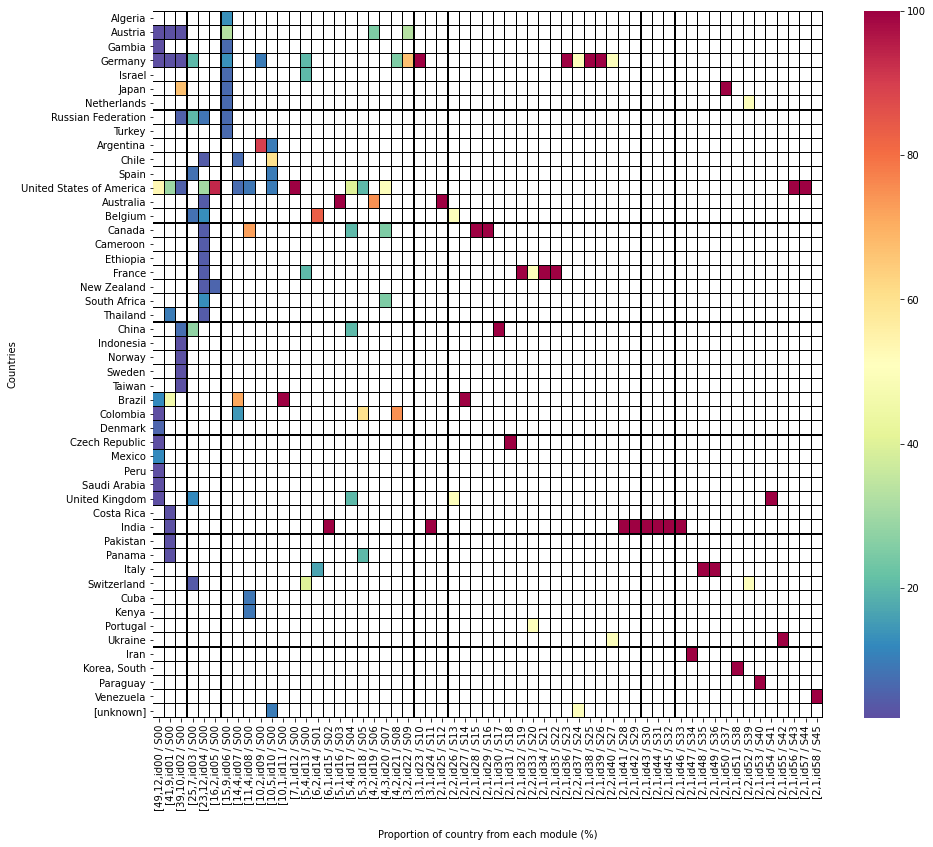

In [22]:
# Plot graph
countries_prop_t = countries_prop.transpose(copy=True)
countries_prop_t[countries_prop_t.columns] = countries_prop_t[countries_prop_t.columns].replace({0: float('nan')})
plt.figure(figsize=(15, 13))
ax = sns.heatmap(countries_prop_t, cmap=plt.get_cmap("Spectral_r"), linecolor="k", linewidths=0.1)
ax.set(xlabel='\nProportion of country from each module (%)', ylabel='Countries')

In [23]:
countries_prop.iloc[3][countries_prop.iloc[3].notnull()]

Germany               20.0
Russian Federation    20.0
Spain                  8.0
Belgium                8.0
China                 28.0
United Kingdom        12.0
Switzerland            4.0
Name:  [25,7,id03 / S00, dtype: float64

In [24]:
# Calculate diversity indices

indices_simpsons = []
indices_shannon = []

for i, idx in enumerate(countries_prop.index):
    country_counts = [x for x in countries_prop.iloc[i].values if not math.isnan(x)]
    
    # indices = countries_prop.iloc[i][countries_prop.iloc[i].notna()].values
    indices_simpsons =  indices_simpsons + [b.simpson(country_counts)]
    indices_shannon =  indices_shannon + [b.shannon(country_counts)]

countries_summary['simpson'] = indices_simpsons
countries_summary['shannon'] = indices_shannon

In [25]:
countries_summary_original = countries_summary.copy(deep=True)

In [26]:
# countries_summary = countries_summary_original.copy(deep=True)

In [27]:
# Scale values by min max for PCA

cols = ['N_authors', 'N_countries', 'simpson']
x = countries_summary[cols].values #returns a numpy array
scaler = preprocessing.StandardScaler()
countries_summary_scaled = pd.DataFrame(scaler.fit_transform(x))

In [28]:
# Perform PCA

pca = PCA(n_components=2, svd_solver='full')
pca.fit(countries_summary_scaled)
pca.values = pca.transform(countries_summary_scaled)
pca.values = pd.DataFrame(pca.values, columns=['PC1', 'PC2'])

var = pca.explained_variance_ratio_
countries_summary = countries_summary.reset_index().merge(pca.values, left_index=True, right_index=True)

In [29]:
# Perform DBSCAN
cluster = KMeans(n_clusters=5, random_state=22).fit(countries_summary[['PC1', 'PC2']].values)
countries_summary['KMeans group'] = cluster.labels_ + 1
countries_summary.loc[countries_summary['KMeans group'] == 0, 'KMeans group'] = "Ungrouped"

In [30]:
countries_summary = countries_summary.sort_values(['idx'])
countries_summary.to_csv(ddir_analysis + "ch3-coauth/2021-02-05-2-modules.csv")
countries_summary[countries_summary.Subgraph_id == 0]

,Modules,N_authors,N_countries,Subgraph_id,idx,simpson,shannon,PC1,PC2,KMeans group
0,8,49.0,12,0,0,0.678785,2.378378,5.499726,1.806716,4
1,9,41.0,9,0,1,0.685465,2.137902,4.366822,1.170280,4
2,7,39.0,10,0,2,0.541759,1.932851,4.208260,1.464996,4
3,12,25.0,7,0,3,0.812800,2.578830,3.224491,-0.264765,2
4,6,23.0,12,0,4,0.849926,3.164224,4.315030,-0.311921,2
5,51,16.0,2,0,5,0.116312,0.335334,0.257744,0.852921,1
6,0,15.0,9,0,6,0.827145,2.868719,3.126769,-0.869172,2
7,15,14.0,4,0,7,0.458591,1.289978,1.239677,-0.122570,5
8,19,11.0,4,0,8,0.446628,1.278431,1.043399,-0.281797,5
9,1,10.0,2,0,9,0.180000,0.468996,0.029813,0.298975,1


/home/ejysoh/miniconda3/envs/msc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


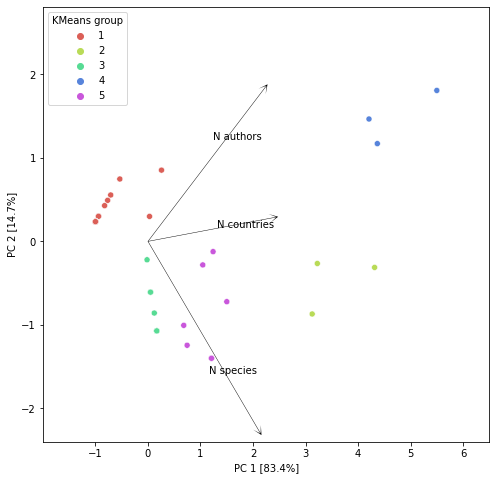

In [31]:
# Get the PCA components (loadings)
PCs = pca.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(8, 8))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:]*4, PCs[1,:]*3, 
           angles='xy', scale_units='xy', scale=1, 
           width = 0.001, headwidth = 20, headlength = 20)

# Add labels based on feature names (here just numbers)
feature_names = ['N authors', 'N countries', 'N species', 'Simpsons']
for i,j,z in zip(PCs[1,:]*2, PCs[0,:]*3, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# # Add unit circle
# circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
# plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
# plt.axis('equal')
plt.xlim([countries_summary['PC1'].min()-1, countries_summary['PC1'].max()+1])
plt.ylim([countries_summary['PC2'].min()-1, countries_summary['PC2'].max()+1])

# Plot value
n_colours = len(countries_summary['KMeans group'].unique())
sns.scatterplot(countries_summary['PC1'], countries_summary['PC2'],  
                hue=countries_summary['KMeans group'], palette=sns.color_palette("hls", n_colours), legend="brief")

# Label axes
xlab = "PC 1 [" + str(round(var[0]*100, 1)) + "%]"
plt.xlabel(xlab)
ylab = "PC 2 [" + str(round(var[1]*100, 1)) + "%]"
plt.ylabel(ylab)

plt.show()

In [32]:
countries_summary.agg({'N_authors': ['count', 'median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max'],
                       'simpson': ['median', 'min', 'max']})

,N_authors,N_countries,simpson
count,59.0,NaN,NaN
median,2.0,1.0,0.000000
min,2.0,1.0,0.000000
max,49.0,12.0,0.849926


In [33]:
# Summary stats for subgraph 1
countries_summary.groupby('KMeans group')\
                 .agg({'N_authors': ['count', 'median', 'min', 'max'],
                       'N_countries': ['median', 'min', 'max'],
                       'simpson': ['median', 'min', 'max']})

# group 1: high authors, low countries, high species, low simpsons = not international, contribute to many species
# group 2: mid authors, mid countries, mid species, high simpsons = international, mid-sized
# group 3: low authors, low countries, low species, mid simpsons = international, small-sized
# group 4: high authors, high countries, high species, high simpsons = international, big-sized
# group 5: low authors, low countries, low species, low simpsons = not international, contribute to few species

N_authors                    N_countries           simpson  \
                 count median   min   max      median min max    median   
KMeans group                                                              
1                   37    2.0   2.0  16.0           1   1   2  0.000000   
2                    3   23.0  15.0  25.0           9   7  12  0.827145   
3                    9    2.0   2.0   6.0           2   2   2  0.500000   
4                    3   41.0  39.0  49.0          10   9  12  0.678785   
5                    7    5.0   4.0  14.0           4   3   5  0.600000   

                                  
                   min       max  
KMeans group                      
1             0.000000  0.180000  
2             0.812800  0.849926  
3             0.278222  0.500000  
4             0.541759  0.685465  
5             0.446628  0.720000

In [34]:
countries_summary.iloc[3]

Modules               12
N_authors           25.0
N_countries            7
Subgraph_id            0
idx                    3
simpson           0.8128
shannon          2.57883
PC1             3.224491
PC2            -0.264765
KMeans group           2
Name: 3, dtype: object

In [35]:
subgraphs_subset = countries_summary[(countries_summary.N_countries>=3) & (countries_summary.Subgraph_id==0)]

spp_li = []
counter = 0
for i, sg in enumerate(subgraphs_subset.index.values):
    for auth in modularity[sg]:
        spp_li = spp_li + list(spp[spp['full_name_of_describer']==auth]['idx'].values)
    counter += 1

spp_li = len(set(spp_li))
n_auth = subgraphs_subset['N_authors'].sum()
from_subgraphs = subgraphs_subset['Subgraph_id'].unique()

print(
    "Authors with >=3 countries accounted for", spp_li, "species for ", counter, " clusters/modules and with", 
    n_auth, "authors from subgraphs", from_subgraphs, "( n=", len(from_subgraphs), ")."
)

Authors with >=3 countries accounted for 1047 species for  10  clusters/modules and with 232.0 authors from subgraphs [0] ( n= 1 ).


In [36]:
# Clusters with only 2 countries
print(len(countries_summary[countries_summary.N_countries==2]))
# Clusters with only 1 country
print(len(countries_summary[countries_summary.N_countries==1]))
# Clusters with only 1 country and 2 authors
print(len(countries_summary[(countries_summary.N_countries==1) & (countries_summary.N_authors <=2)]))

11
35
29


In [37]:
print(countries_summary[countries_summary['KMeans group']==1], "\n")

# Brazil group and US/New Zealand group ("old")
print(modularity[9], "\n")
print(modularity[10])

    Modules  N_authors  N_countries  Subgraph_id  idx   simpson   shannon  \
5        51       16.0            2            0    5  0.116312  0.335334   
9         1       10.0            2            0    9  0.180000  0.468996   
11       14       10.0            1            0   11  0.000000 -0.000000   
12       56        7.0            1            0   12  0.000000 -0.000000   
15       39        6.0            1            2   15  0.000000 -0.000000   
16        4        5.0            1            3   16  0.000000 -0.000000   
23       31        3.0            1           10   23  0.000000 -0.000000   
24       37        3.0            1           11   24  0.000000 -0.000000   
25        3        2.0            1           12   25  0.000000 -0.000000   
27       16        2.0            1           14   27  0.000000 -0.000000   
28       17        2.0            1           15   28  0.000000 -0.000000   
29       18        2.0            1           16   29  0.000000 -0.000000   

In [38]:
countries_df_m2 = countries_df.loc[countries_df.count(axis=1) > 2] # countries with <=2
print(countries_df_m2.count(axis=0).sort_values(ascending=False)[0:10])

countries_df_l2 = countries_df.loc[countries_df.count(axis=1) < 2] # countries with <=2
print(countries_df_l2.count(axis=0).sort_values(ascending=False)[0:10])

US    10
GM     6
CA     4
RS     4
AU     4
UK     3
CO     3
BR     3
CI     3
CH     3
dtype: int64
IN    8
GM    4
US    3
FR    3
IT    2
CA    2
AS    2
BR    2
CH    1
UK    1
dtype: int64


In [39]:
countries_summary.sort_values('idx')

,Modules,N_authors,N_countries,Subgraph_id,idx,simpson,shannon,PC1,PC2,KMeans group
0,8,49.0,12,0,0,0.678785,2.378378,5.499726,1.806716,4
1,9,41.0,9,0,1,0.685465,2.137902,4.366822,1.170280,4
2,7,39.0,10,0,2,0.541759,1.932851,4.208260,1.464996,4
3,12,25.0,7,0,3,0.812800,2.578830,3.224491,-0.264765,2
4,6,23.0,12,0,4,0.849926,3.164224,4.315030,-0.311921,2
5,51,16.0,2,0,5,0.116312,0.335334,0.257744,0.852921,1
6,0,15.0,9,0,6,0.827145,2.868719,3.126769,-0.869172,2
7,15,14.0,4,0,7,0.458591,1.289978,1.239677,-0.122570,5
8,19,11.0,4,0,8,0.446628,1.278431,1.043399,-0.281797,5
9,1,10.0,2,0,9,0.180000,0.468996,0.029813,0.298975,1


In [40]:
countries_summary[countries_summary['KMeans group'] == 5]

,Modules,N_authors,N_countries,Subgraph_id,idx,simpson,shannon,PC1,PC2,KMeans group
7,15,14.0,4,0,7,0.458591,1.289978,1.239677,-0.122570,5
8,19,11.0,4,0,8,0.446628,1.278431,1.043399,-0.281797,5
10,2,10.0,5,0,10,0.600000,1.770951,1.500980,-0.721787,5
13,27,5.0,4,0,13,0.720000,1.921928,1.209464,-1.399341,5
17,21,5.0,4,4,17,0.720000,1.921928,1.209464,-1.399341,5
18,23,5.0,3,5,18,0.560000,1.370951,0.681495,-1.005330,5
20,20,4.0,3,7,20,0.625000,1.500000,0.745696,-1.243833,5


In [41]:
countries_summary[countries_summary['Subgraph_id'] == 0].sort_values(['N_authors'], ascending=False)

,Modules,N_authors,N_countries,Subgraph_id,idx,simpson,shannon,PC1,PC2,KMeans group
0,8,49.0,12,0,0,0.678785,2.378378,5.499726,1.806716,4
1,9,41.0,9,0,1,0.685465,2.137902,4.366822,1.170280,4
2,7,39.0,10,0,2,0.541759,1.932851,4.208260,1.464996,4
3,12,25.0,7,0,3,0.812800,2.578830,3.224491,-0.264765,2
4,6,23.0,12,0,4,0.849926,3.164224,4.315030,-0.311921,2
5,51,16.0,2,0,5,0.116312,0.335334,0.257744,0.852921,1
6,0,15.0,9,0,6,0.827145,2.868719,3.126769,-0.869172,2
7,15,14.0,4,0,7,0.458591,1.289978,1.239677,-0.122570,5
8,19,11.0,4,0,8,0.446628,1.278431,1.043399,-0.281797,5
9,1,10.0,2,0,9,0.180000,0.468996,0.029813,0.298975,1


In [42]:
print(np.median(countries_summary[countries_summary['Subgraph_id'] == 0].simpson))
print(np.min(countries_summary[countries_summary['Subgraph_id'] == 0].simpson))
print(np.max(countries_summary[countries_summary['Subgraph_id'] == 0].simpson))

0.570879398886857
0.0
0.8499260119693947


In [43]:
# Test the function on module 0
get_highest_eigen_in_module(51)

Number of nodes:  16  in module  51 

Modularity Sorted by Eigenvector Centrality:
Theodore Dru Alison Cockerell |  0.0064376016551930424  |  US
Edward Sharpe Gaige Titus |  0.0007956744402101933  |  US
Alice Barringer Mackie |  0.000783877263315847  |  NZ
Beulah Hix Blair |  0.000783877263315847  |  US
Charles H. Hicks |  0.000783877263315847  |  US
Grace Adelbert Sandhouse |  0.000783877263315847  |  US
Henry Lorenz Viereck |  0.000783877263315847  |  US
Jessie E. Casad |  0.000783877263315847  |  US
John Harvey Lovell |  0.000783877263315847  |  US
Louise M. Ireland |  0.000783877263315847  |  US





/home/ejysoh/miniconda3/envs/msc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, '\n Number of countries'), Text(0, 0.5, 'Number of authors')]

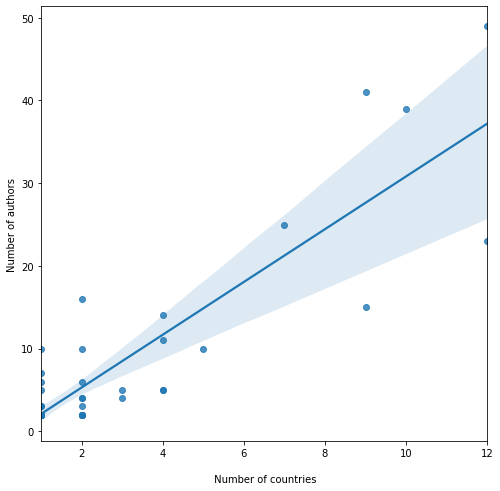

In [44]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(countries_summary['N_countries'], countries_summary['N_authors'])
ax.set(xlabel='\n Number of countries', 
       ylabel='Number of authors')

In [45]:
[get_highest_eigen_in_module(x) for x in countries_summary[countries_summary.N_authors>=10].index.values]

Number of nodes:  15  in module  0 

Modularity Sorted by Eigenvector Centrality:
Maximilian Schwarz |  0.08084146449549443  |  AU
Fritz Josef [Friedrich] Gusenleitner |  0.01635333120213761  |  AU
Karl Mazzucco |  0.012015231943082728  |  AU
Esther Ockermüller |  0.011209840199713222  |  AU
Jan Smit |  0.011209840199713222  |  NL
Klaus Standfuss |  0.00984467927893155  |  GA
Timofey Victorovich Levchenko |  0.00984467927893155  |  RS
Erwin Scheuchl |  0.006744632643034571  |  GM
Ardeshir Ariana |  0.0062729046007867755  |  JA
Gerald Hölzler |  0.0014633793955146125  |  AU



Number of nodes:  10  in module  1 

Modularity Sorted by Eigenvector Centrality:
Mariano Lucia |  0.03892360298128937  |  AR
Alberto H. Abrahamovich |  0.019653001273778548  |  AR
Leopoldo J. Alvarez |  0.014641130915029601  |  AR
Silvana P. Durante |  0.00724861898028626  |  AR
Arturo Roig-Alsina |  0.0009532832070745064  |  AR
Juan Pablo Torretta |  0.00011607369668554397  |  AR
Luis A. Compagnucci |  0.0001160

[None, None, None, None, None, None, None, None, None, None, None, None]